This script compares the impact of inaccuracies in the reference graph. More specifically, we consider an SBM with no edges between nodes on different communities as the true graph, and for the reference graph, we progressively increase the probability of edges between nodes in different communities to check how the difference affects the performance.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils

# %matplotlib qt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
def run_exp(id, models, QQ0, iters):
    # Create graph
    A = nx.to_numpy_array(nx.random_partition_graph(block_sizes, p, q))
    L = np.diag(np.sum(A, 0)) - A
    lamds, _ = np.linalg.eigh(L)

    # Create covariance
    X = utils.create_signals(L, M)
    C_hat = X@X.T/M

    L_hat = np.zeros((N, N, len(models), len(QQ0)))
    lamd_hat = np.zeros((N, len(models), len(QQ0)))
    cs_err = np.zeros((len(models), len(QQ0)))
    for i, q0 in enumerate(QQ0):
        # Create reference graph
        A0 = nx.to_numpy_array(nx.random_partition_graph(block_sizes0, p, q0))
        L0 = np.diag(np.sum(A0, 0)) - A0
        lambdas0, _ = np.linalg.eigh(L0)

        for j, model in enumerate(models):
            if model['name'] == 'MGL-Tr=1':
                model['cs'] = 1
            elif 'gs' in model.keys() and model['gs']:
                model['cs'], cs_err[j,i] = utils.compute_cs(model['gs'], lambdas0, lamds)
                cs_err[j,i] /= model['cs']

            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters)
            t = time.time() - t
            print('Graph-{}, q0-{}: Model: {} - cs: {:.4f} - Time(sec): {:.3}'.
                  format(id, q0, model['name'], cs_err[j,i], t))
    return L_hat, lamd_hat, L, lamds, cs_err


def est_errs1(Ls, lamds, L_hat, lams_hat, sq_err=True):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        L = Ls[:,:,k]
        lamd = lamds[:,k]
        norm_L = np.linalg.norm(L, 'fro')
        norm_lam = np.linalg.norm(lamd, 2)

        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                err_L[j,i,k] = np.linalg.norm(L-L_hat[:,:,j,i,k], 'fro')/norm_L
                err_lamb[j,i,k] = np.linalg.norm(lamd-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def est_errs2(Ls, lamds, L_hat, lams_hat, sq_err=True):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        L = Ls[:,:,k]
        lamd = lamds[:,k]
        norm_L = np.linalg.norm(L, 'fro')
        norm_lam = np.linalg.norm(lamd, 2)

        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(QQ, models, err, ylab, logy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if logy:
            plt.loglog(QQ, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.semilogx(QQ, err[i,:], model['fmt'], label=model['name'],
                         linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Inter-cluster edge prob')
        plt.ylabel(ylab)
        plt.legend()
        # plt.xlim([QQ[0], QQ[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()

## Experiment parameters

In [3]:
# Experiment variables
QQ0 = np.logspace(-6, np.log10(.5), 10)  # [1e-4, .01, .1,]  # 
M = 1000
n_graphs = 50
iters = 200

# Graph parameters
K = 5
block_sizes0 = [30]*K
block_sizes = [30]*K
# block_sizes = [20]*K
p = .3
q = 0
N0 = sum(block_sizes0)
N = sum(block_sizes)   

GS = [
    lambda a, b : cp.sum(a)/b,    # delta: 4e-2
    lambda a, b : cp.sum(a**2)/b,  # delta: .7
    lambda a, b : cp.sum(cp.exp(-a))/b,    # delta: 3e-3
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

# With N=150
deltas = [.7, 10, .003, 3]
models = [
    # Baselines
    {'name': 'GLasso', 'alpha': 0.01, 'fmt': '^--'},
    {'name': 'MGL-Tr=1', 'gs': GS[0], 'bounds': [], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 0.2, 'gamma': 0, 'deltas': 1e-4}},
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': .2, 'c1': 1, 'c2': 20, 'conn_comp': K}},

    # Our algorithms
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': .2, 'gamma': 0, 'deltas': deltas[0]}},
    {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
     'regs': {'alpha': 0, 'beta': .2, 'gamma': 500, 'deltas': deltas[1]}},
    {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
     'regs': {'alpha': .01, 'beta': .5, 'gamma': 1, 'deltas': deltas[2]}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': .3, 'gamma': 1000, 'deltas': deltas[3]}},
]

# # N=100
# # deltas = [2.9, 45, .06, 11]
# models = [
#     # Baselines
#     {'name': 'GLasso', 'alpha': 0.01, 'fmt': '^--'},
#     {'name': 'MGL-Tr=1', 'gs': GS[0], 'bounds': [], 'fmt': '2--',
#      'regs': {'alpha': 0, 'beta': 0.2, 'gamma': 0, 'deltas': 1e-4}},
#     {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': .05, 'beta': .7, 'c1': 1, 'c2': 20, 'conn_comp': K}},

#     # Our algorithms
#     {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
#      'regs': {'alpha': 0, 'beta': .2, 'gamma': 0, 'deltas': deltas[0]}},
#     {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
#      'regs': {'alpha': 0, 'beta': .2, 'gamma': 500, 'deltas': deltas[1]}},
#     {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
#      'regs': {'alpha': .01, 'beta': .5, 'gamma': 1, 'deltas': deltas[2]}},
#     {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
#      'regs': {'alpha': 0, 'beta': .3, 'gamma': 1000, 'deltas': deltas[3]}},
# ]

# # Alernative regs
# models = [
#     # Baselines
#     {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': .05, 'beta': .7, 'c1': 1, 'c2': 20, 'conn_comp': K}},

#     # Our algorithms
#     {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': '2-',
#      'regs': {'alpha': 0, 'beta': .5, 'gamma': 0, 'deltas': 1-4}},
#     {'name': 'MGL-Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'fmt': 'o-',
#      'regs': {'alpha': 0, 'beta': 1, 'gamma': 1000, 'deltas': deltas[1]}},
#     {'name': 'MGL-Heat', 'gs': GS[2], 'bounds': BOUNDS[1], 'fmt': 'x-',
#      'regs': {'alpha': .05, 'beta': .8, 'gamma': 1, 'deltas': deltas[2]}},
#     {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
#      'regs': {'alpha': 0, 'beta': 1, 'gamma': 1000, 'deltas': deltas[3]}},
# ]


## Estimate graphs

In [4]:
total_t = time.time()
Ls = np.zeros((N, N, n_graphs))
lamds = np.zeros((N, n_graphs))
Ls_hat = np.zeros((N, N, len(models), len(QQ0), n_graphs))
lamds_hat = np.zeros((N, len(models), len(QQ0), n_graphs))
cs_err = np.zeros((len(models), len(QQ0), n_graphs))

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models, QQ0, iters) for i in range(n_graphs))

for i, resp in enumerate(resps):
    Ls_hat[:,:,:,:,i], lamds_hat[:,:,:,i], Ls[:,:,i], \
        lamds[:,i], cs_err[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 5.022662615776062  mins -----


<ipython-input-2-75ff58bdfa42>:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()
<ipython-input-2-75ff58bdfa42>:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()
<ipython-input-2-75ff58bdfa42>:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


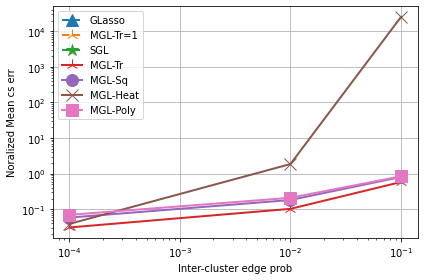

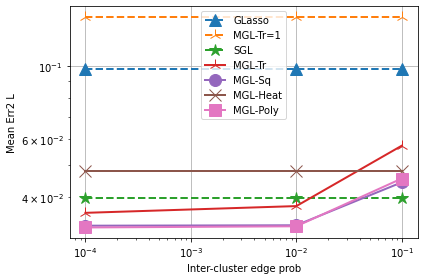

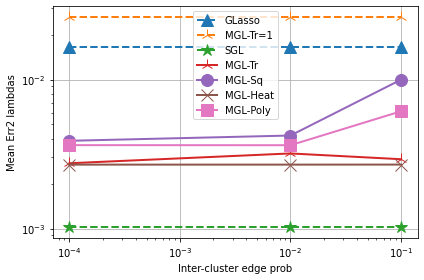

In [5]:
err_L, err_lamb = est_errs2(Ls, lamds, Ls_hat, lamds_hat)
mean_cs_err = np.abs(np.mean(cs_err, 2))
mean_err_L = np.median(err_L, 2)
mean_err_lam = np.mean(err_lamb, 2)
plot_err(QQ0, models, mean_cs_err, 'Noralized Mean cs err', logy=True)
plot_err(QQ0, models, mean_err_L, 'Mean Err2 L')
plot_err(QQ0, models, mean_err_lam, 'Mean Err2 lambdas')

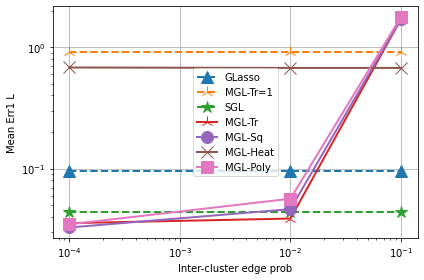

In [6]:
err_L, _ = est_errs1(Ls, lamds, Ls_hat, lamds_hat)
mean_err_L = np.median(err_L, 2)
plot_err(QQ0, models, mean_err_L, 'Mean Err1 L')

In [7]:
# # Save data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models]
# data = {
#     'Ls': Ls,
#     'lamds': lamds,
#     'Ls_hat': Ls_hat,
#     'lamds_hat': lamds_hat,
#     'cs_err': cs_err,
#     'QQ0': QQ0,
#     'iters' : iters,
#     'models': models_aux,
#     'M': M,
# }
# file = 'ref-errs_{}graphs_{}iters_{}M'.format(n_graphs, iters, M)
# np.save('results/ref_graph_errs/' + file, data)

In [8]:
# # Load data
# %matplotlib qt
# file = 'results/graph_density/density_50graphs_200iters_1000M.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# Ls = data['Ls']
# lamds = data['lamds']
# Ls_hat = data['Ls_hat']
# lamds_hat = data['lamds_hat']
# QQ0 = data['QQ0']
# iters = data['iters']
# models = data['models']
# M = data['M']